In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
import shutil
import random

#Constants

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
original_train_dir = 'drive/MyDrive/datasets/train'
original_val_dir = 'drive/MyDrive/datasets/val'

# Paths to the subset directories
subset_train_dir = 'drive/MyDrive/datasets/train_subset'
subset_val_dir = 'drive/MyDrive/datasets/val_subset'

# Desired number of samples
num_train_samples = 2000
num_val_samples = 500

# Function to create a subset directory with a random selection of images
def create_subset(original_dir, subset_dir, num_samples):
    # Create the subset directory if it doesn’t exist
    if not os.path.exists(subset_dir):
        os.makedirs(subset_dir)

    # Iterate over class subdirectories (e.g., 'class_0', 'class_1')
    for class_dir in os.listdir(original_dir):
        class_path = os.path.join(original_dir, class_dir)
        subset_class_path = os.path.join(subset_dir, class_dir)

        # Create class subdirectory in the subset directory
        if not os.path.exists(subset_class_path):
            os.makedirs(subset_class_path)

        # Randomly sample images from the class directory
        images = os.listdir(class_path)
        selected_images = random.sample(images, min(len(images), num_samples // len(os.listdir(original_dir))))

        # Copy selected images to the subset directory
        for img in selected_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(subset_class_path, img))

# Create subsets for training and validation directories
if not os.path.exists(subset_train_dir):
  create_subset(original_train_dir, subset_train_dir, num_train_samples)
if not os.path.exists(subset_val_dir):
  create_subset(original_val_dir, subset_val_dir, num_val_samples)

In [ ]:
train_dir = 'drive/MyDrive/datasets/train'
val_dir = 'drive/MyDrive/datasets/val'
test_dir = 'drive/MyDrive/datasets/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,            # Normalizing pixel values to [0, 1]
    rotation_range=45,         # Randomly rotate images by up to 40 degrees
    zoom_range=0.2,            # Random zoom
    horizontal_flip=True,      # Randomly flip images horizontally
    fill_mode='nearest'        # Filling in new pixels with nearest ones after transformations
)


val_datagen = ImageDataGenerator(
    rescale = 1./255      # Normalizing pixel values to [0, 1]
)

# Raw pixel values in most images are stored as integers between 0 and 255 since they are typically 8 bit values
# By diving by 255, we normalize to range of [0,1]


train_generator = train_datagen.flow_from_directory(
    train_dir,                    # Path to the validation data directory
    shuffle = True,
    target_size=IMG_SIZE,     # Resizing all images to 150x150
    batch_size=BATCH_SIZE,              # Batch size for validation
    class_mode='binary'         # For binary classification
)


val_generator = val_datagen.flow_from_directory(
    val_dir,                    # Path to the validation data directory
    target_size=IMG_SIZE,     # Resizing all images to 150x150
    batch_size=BATCH_SIZE,              # Batch size for validation
    class_mode='binary'         # For binary classification
)


Found 20004 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


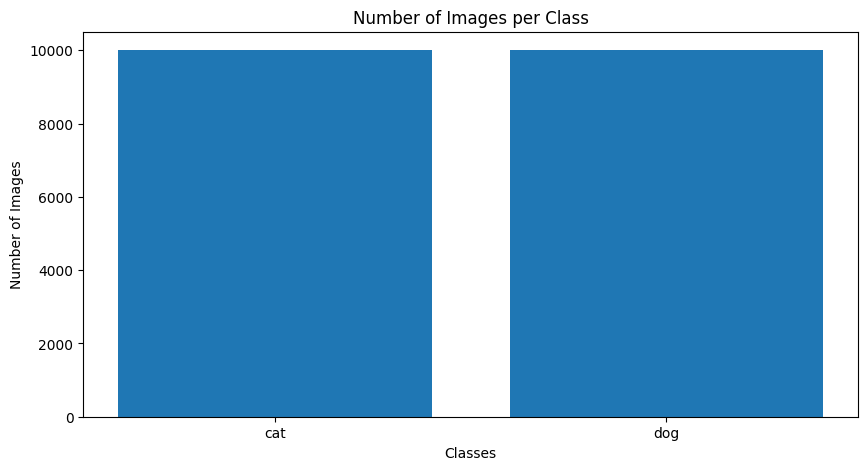

In [ ]:
class_counts = train_generator.classes
class_labels = list(train_generator.class_indices.keys())

images, labels = next(train_generator)

unique_classes, counts = np.unique(class_counts, return_counts=True)

# Create the bar plot
plt.figure(figsize=(10, 5))
plt.bar(class_labels, counts)
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Number of Images per Class")
plt.show()



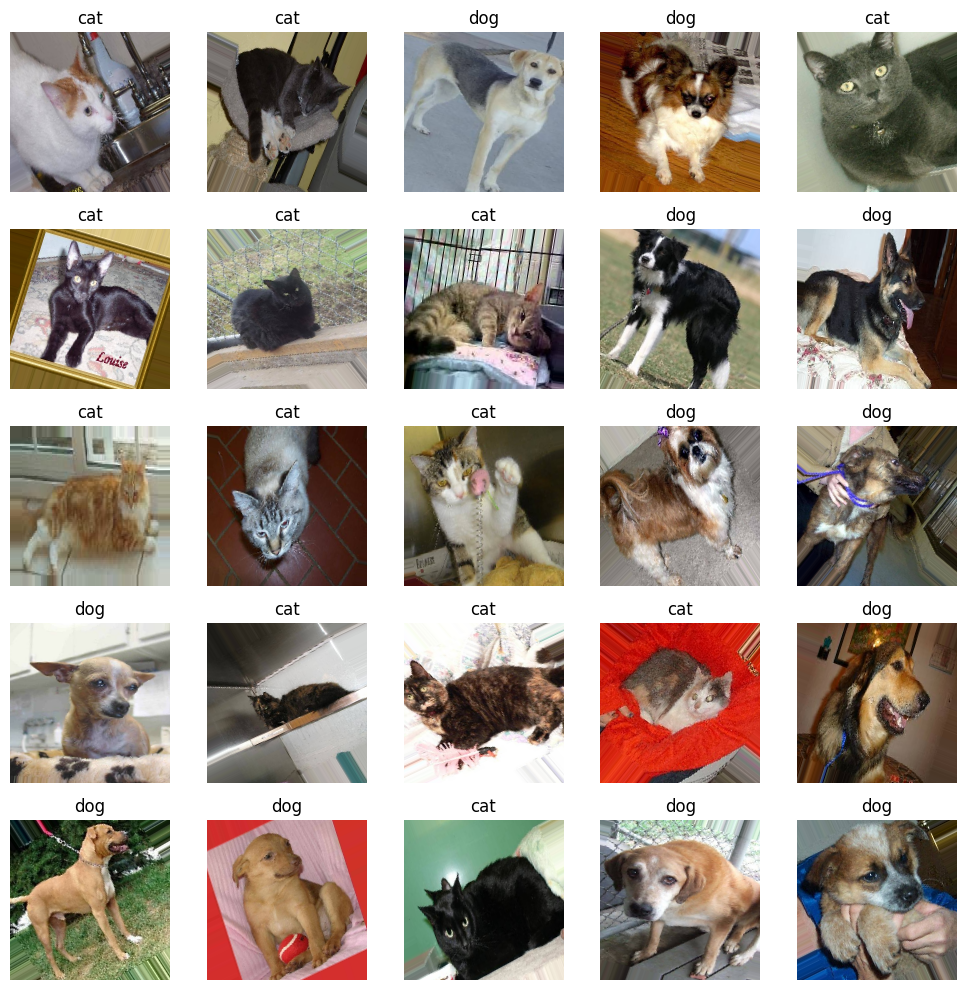

In [ ]:
# Set the number of images to display
num_images = 25
plt.figure(figsize=(10, 10))

# Display the images
for i in range(num_images):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])
    plt.title(class_labels[int(labels[i])])
    plt.axis('off')

plt.tight_layout()
plt.show()

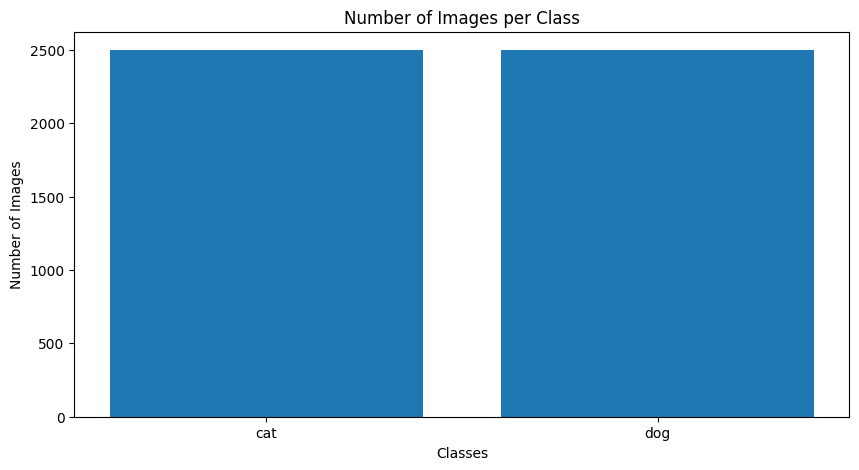

In [ ]:
class_counts = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Count the occurrences of each class
unique_classes, counts = np.unique(class_counts, return_counts=True)

# Create the bar plot
plt.figure(figsize=(10, 5))
plt.bar(class_labels, counts)
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Number of Images per Class")
plt.show()

In [ ]:
# Initialize ResNet50 layers with ImageNet weight (pre-trained)
base_model  = tf.keras.applications.resnet.ResNet50(
    include_top=False,
    input_shape = (160, 160, 3),
    weights='imagenet',
    pooling='max',
    classes=2,
)

base_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 160, 160, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 166, 166, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 80, 80, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 80, 80, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 80, 80, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 82, 82, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 40, 40, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 40, 40, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 40, 40, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 40, 40, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 40, 40, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 40, 40, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 40, 40, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 40, 40, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 40, 40, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
# Freeze the base model layers
base_model.trainable = False

# Create a new model on top
inputs = keras.Input(shape=(160, 160, 3))
x = base_model(inputs, training=False)
x = keras.layers.Dropout(0.3)(x)  # Add dropout for regularization
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
epochs = 5  # Adjust as needed
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator
)


# Fine-tuning: Unfreeze some layers of the base model and retrain with a very low learning rate
base_model.trainable = True

# # Fine-tune from a specific layer onwards (e.g., from the 100th layer)
# fine_tune_at = 100  # Adjust as needed

# for layer in base_model.layers[:fine_tune_at]:
#     layer.trainable = False

# Recompile the model with a lower learning rate
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), # Very low learning rate
              loss='binary_crossentropy',
              metrics=['accuracy'])


# Continue training
fine_tune_epochs = 15 # Adjust as needed
total_epochs = epochs + fine_tune_epochs

history_fine = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1], # Continue from previous epoch
    validation_data=val_generator
)



#Parameter Tuning Explanation and Strategies:

#1. Learning Rate:
#   - Initial learning rate (0.0001 in the example): Start with a low learning rate for initial training to prevent drastic weight changes.
#   - Fine-tuning learning rate (1e-5): Significantly lower learning rate for fine-tuning because we want to make smaller adjustments to the pre-trained weights.
#   - Tuning Strategy: Experiment with different learning rates. You can use learning rate schedules (e.g., reduce on plateau) or cyclical learning rates.

#2. Dropout Rate:
#   - Dropout (0.5 in the example) is a regularization technique that prevents overfitting by randomly dropping out neurons during training.
#   - Tuning Strategy: Experiment with different dropout rates (0.2, 0.3, 0.4, 0.5, 0.6) to find the best value for your model.

#3. Fine-tune at Layer:
#   - The 'fine_tune_at' parameter determines the number of layers in the base model to freeze during the initial training phase and those unfrozen for fine-tuning.
#   - Tuning Strategy: Experiment with different layer values. Start with freezing more layers and gradually unfreeze more as you progress.  Use the summary output to help identify which layers are good candidate.

#4. Number of Epochs:
#   - Epochs are the number of times the model sees the entire training dataset.
#   - Tuning Strategy: Monitor validation accuracy for overfitting. Stop training when validation accuracy plateaus or starts decreasing.


#5. Data Augmentation Parameters (in ImageDataGenerator):
#   - rotation_range, zoom_range, horizontal_flip, fill_mode, etc.
#   - Tuning Strategy: These parameters add randomness to the training data. Experiment with different settings to improve model robustness.  Too much augmentation could hurt training.

#6. Batch Size:
#   - The batch size affects the update frequency of the model's weights.
#   - Tuning Strategy: Typical batch sizes are 32 or 64, though others may work.  If there are not enough memory resources, the batch size must be lowered.


#General Tuning Strategies:
#  - Use a validation set: Monitor your model's performance on the validation set during training to detect overfitting.
#  - Cross-validation: If you have limited data, consider using k-fold cross-validation.
#  - Grid Search/Random Search: Systematically search over a range of hyperparameter values.
#  - Early Stopping: Stop training when validation performance no longer improves.

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 11/626 ━━━━━━━━━━━━━━━━━━━━ 3:50:34 22s/step - accuracy: 0.5429 - loss: 0.9573

In [ ]:
import pandas as pd
import os
from tensorflow import keras

# Load your trained model
testmodel  = history_fine

# Define the directory containing the test images
test_dir = 'drive/MyDrive/datasets/test'

# Create an empty list to store the results
results = []

# Iterate over the images in the test directory
for filename in os.listdir(test_dir):
    if filename.endswith(('.jpg', '.jpeg', '.png')):  # Check for image files
        image_path = os.path.join(test_dir, filename)

        # Load and preprocess the image
        img = keras.preprocessing.image.load_img(image_path, target_size=(160, 160))  # Adjust target_size if necessary
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.  # Normalize pixel values

        # Make the prediction
        prediction = model.predict(img_array)

        # Assuming binary classification, get the predicted class (0 or 1)
        predicted_class = class_labels[int(round(prediction[0][0]))]  # or np.argmax(prediction) for multi-class

        # Append the results to the list
        results.append([filename, predicted_class])

# Create a Pandas DataFrame from the results
df = pd.DataFrame(results, columns=['Image Name', 'Predicted Value'])

# Save the DataFrame to a CSV file
df.to_csv('predictions.csv', index=False)

print("Predictions saved to predictions.csv")